# Document Annotation

Almost all tasks you want to do can be decsribed as document annotation tasks: you have some text, and you want to apply a label or set of labels to it.  Maybe they're class labels (document classification), or a continuing value (regression).  LLMs are great for this--and you don't need the state-of-the-art models to get extremely good results, making this angle much more accessible than the large generative models tend to be.

We'll re-use the same classification task from the zero-shot learning examples: identify positive/negative reviews.

In [1]:
import datasets
import numpy as np
from sklearn.model_selection import train_test_split

# use the smaller (10k reviews per star rating) test set--just for speed
data = datasets.load_dataset("yelp_review_full", split="test")

y = np.array(data["label"])
x = np.array(data["text"])

# SPEED TWEAK: only 1/5 star reviews.  Coded as 0-4 in the dataset.
# Comment these 4 lines out to use all 5 star ratings.
keep = (y == 0) | (y == 4)
x = x[keep]
y = y[keep]
y = (y / 4).astype(int)

# train-test split; use 80% for training
train_x, test_x, train_y, test_y = train_test_split(
    x,
    y,
    train_size=0.8,
    stratify=y,
    random_state=0,
)

print(f"{len(train_x):,} training observations, {len(test_x):,} testing observations")

16,000 training observations, 4,000 testing observations


# Digression: LLMs may not be necessary

Document annotation--especially classification--is an extremely well-trod area of study.  There are a lot of extremely fast ways to do document classification with very high accuracy, and you should always try these out before reaching for LLMs.

As a quick demo, we'll use an extremely simple, no-frills modeling approach: Bag-of-Words + Naive Bayes.
- Bag-of-Words: convert text into a numeric/vectorized representation by counting how often the document uses each possible word.
- Naive Bayes: for each feature (word), calculate the conditional probability of each class (star rating), given the value of the current feature (number of times the word was used).  To make predictions, calculate these probabilities for each document and feature, then assign it to the class with the highest probability.  (further details are beyond the scope of this workshop)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

clf = Pipeline([
    # filter out super rate words and super common words--words should be in >10 documents
    # and in <= 50% of all documents.  Extremely low and high frequency words rarely tell
    # us much.
    ("vectorizer", CountVectorizer(min_df=10, max_df=0.5)),
    ("clf", ComplementNB()),
])

# `%time` is a Jupyter "magic command" that will time how long the following statement takes,
# and print out the duration.
%time clf.fit(train_x, train_y)
%time preds = clf.predict(test_x)
    
# Calculate F1, a pretty common classification error metric
from sklearn.metrics import r2_score, f1_score
f1 = f1_score(test_y, preds, average="macro")
print(f"Macro F1 on testing data (1 = perfect classification): {f1}")

CPU times: total: 1.97 s
Wall time: 3.09 s
CPU times: total: 328 ms
Wall time: 785 ms
Macro F1 on testing data (1 = perfect classification): 0.9189992709934389


And for good measure, let's generate a confusion matrix to visualize the predictions.

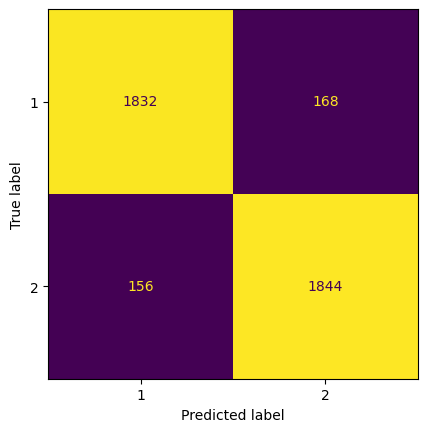

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fix, ax = plt.subplots()
# star labels are 0-4 in the dataset; convert to 1-5 for displaying here.
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=test_y + 1,
    y_pred=preds + 1,
    ax=ax,
    colorbar=False,
)
plt.show()

So, in under a second, running on a single CPU core, we can get _really_ good predictions, using older and simpler methods.  LLMs, as we'll see, require a lot more compute power (i.e. dedicated GPUs), and are a lot slower.  But they can be more accuracy.

There are very few document annotation tasks where you _need_ an LLM.  They often provide the best-in-class accuracy (but not always by a huge margin), but at the cost of added time and compute power, which might be a deal breaker.

# Document Classification with LLMs

Let's see the same thing done with LLMs.  _Note:_ there will be a _lot_ more code here than for the `scikit-learn` example above.  None of the code is particularly complicated, but there is quite a lot of it.  `scikit-learn` hides a lot of implementation details away from us, but when we're working with Huggingface's models, we need to do a lot more of the work ourselves.  Again, none of the code is hard, but it might be ticky if you don't have a good foundation in the machine learning/neural network worlds.

## Heads up: Some tweaks for speed

LLMs and neural networks can take a _very_ long time to train.  We're going to make a few tweaks throughout this notebook to make them run faster, often by simplifying what they're actually doing.  We'll make two _big_ speed tweaks:
1. We're doing 1-versus-5-star classification, rathe than 1/2/3/4/5-star classification.  This leaves us with less data to process, and is a simpler problem to solve, so the model should be able to converge more quickly.
2. We're freezing the parameters of the LLM itself.  Normally, we'd be updating the weights of LLM as we train, in addition to the single densely connected layer that gets appended to the end of it to do classification.  For this notebook, we'll only be training that last layer.  This lets us iterate through the data more quickly, but might require more iterations to converge on a good solution.  Note that, by doing this, we're just using the LLM as a (really good, but slow) text vectorizer.  This is a perfectly sensible thing to do, especially in more compute-constrained settings where fine-tuning the whole model might not be feasible.  But, in those cases, you'd probably feed all your texts through the LLM to get the vectorized outputs, then save those, and train a model of your choice on them directly.  This would be a bit more complicated, but could be a lot more convenient (and faster, if you need to make more than one pass over your data).
3. We're limiting ourselves to one pass over the data.  Normally we would keep iterating for as long as it takes for the model to converge.

If we didn't do these tweaks, all we'd get is a longer runtime; nothing is really getting hidden or made simpler.  If you want to run this code without these tweaks, look for comments that start with "SPEED TWEAK:" throughout the next few cells.

# Picking a Model

There are _lots_ of LLM models out there for classification and regression tasks--more than there are in the generative world.  And you can run a lot more of them on consumer-grade hardware, so there's also more to pick from in practical terms.  However, most of the different models are largely interchangeable for most tasks.

There are a few models you can use to get started in the `transformers` library:
- `bert-base-uncased` and `bert-base-cased`: the classic, standard BERT models that started the current wave of Transformer models.  Still a great choice for almost eveything!  (`bert-base-uncased` is _not_ case-sensitive; it treats "English" and "ENGLISH" as the same; `bert-base-cased` _is_ case-sensitive).
- `distilbert/distilbert-base-uncased` and `distilbert/distilbert-bsae-cased`: DistilBERT, a smaller/reduced-size version of the classic BERT models.  It's about twice as fast, uses about half the memory, and is about 95% as accurate.  (A _great_ default first model, due to its relative speed).
- `FacebookAI/roberta-base`: RoBERTa, a variant of BERT trained with a slightly different training objective, which typically out-performs BERT by a small margin across the board, with no extra compute.
- `distilbet/distilrobeta-base`: a distilled version of RoBERTa.  (This one is causing issues for me, but maybe you'll have better luck)
- `google/fnet-base`: FNet, which replaces the self-attention in transformers with a 2d Fourier transform.  It's a lot smaller, though not a lot faster, than similar models.
- `xlnet/xlnet-base-cased`: XLNet, the first big autoregressive model (--> it has no maximum input length).  Note that this requires handling tokenization differently, and ensuring each input batch is padded to the same length, and will require some changes to the code below (like removing the use of the `MAX_LENGTH` global variable, which will be set absurdly high for autoregressive models).

`transformers` makes it pretty trivial to swap out one model for another, so feel free to experiment with different models in their repository.  For a full list of all models supported by all Huggingface libraries, see [the Huggingface Model Hub](https://huggingface.co/models).  If you want to see a comparison of models, a good place to start is the [Open LLM Leaderboard](https://huggingface.co/open-llm-leaderboard).

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# the name of the model we'll use
model = "distilbert/distilbert-base-uncased"

# Loahttps://github.com/andersonh-uta/LASI2024d the tokenizer for the model
tok = AutoTokenizer.from_pretrained(model, use_fast=True)

# Load the model itself.  We need to tell it how many values out target variable has.
# In our case, it's just however many unique values are in our `y` values.
clf = AutoModelForSequenceClassification.from_pretrained(
    model,
    num_labels=len(set(y))
)

# PyTorch can compile models for a possibly quite large speedup.  But this is not
# supported for all combinations of Python and PyTorch versions.
# Note that on some configurations, this can still result in errors,
# so it's commented out entirely for now.
# import sys
# if sys.version_info.minor <= 12 or torch.__version__.split(".")[1] >= "4":
#     clf = torch.compile(clf)
# else:
#     print(
#         f"Cannot compile the model.  Need a Python version *prior to* 3.12 (you have: {sys.version}), or "
#         f"a PyTorch version 2.4.0 or later (you have: {torch.__version__}"
#     )

# Move the model to the GPU if one is available.  Otherwise this will run
# on the CPU, and be so slow that it's basically unusable.
if torch.cuda.is_available():
    clf = clf.to("cuda")
    
# SPEED TWEAK: Freeze all the layers in the base model.
for p in clf.base_model.parameters():
    p.requires_grad = False

# max length for the tokenizer--so it knows how much to pad each 
# observation if it's too short.
global MAX_LENGTH
MAX_LENGTH = clf.config.max_position_embeddings

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Prep work

PyTorch models--which we're using--require some potentially fiddly setup work to get the data prepared.  We need our data to be shuffled, so that we're iterating through it in a randomized order.  PyTorch provides a `Dataset` and `DataLoader` class we can use, but the basic functionality is easy to re-write yourself.

In [5]:
# Do a bunch of the fiddly stuff required for the PyTorch API.
# Namely:
#    - Get a DataLoader to make batching, shuffling and iterating
#      a bit easier.  We'll do this using the tokenized data--
#      not the raw strings--so that we minimize how often we're
#      running the tokenizer.  (--> should run a bit faster).
#    - One-hot encode the y-values; scikit-learn does this for us
#      under the hood, but PyTorch expects us to do this beforehand.
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch

# subclass the Dataset class; this will provide some utilities for iteration and
# shuffling and such, and will make a few things easier/cleaner later.
class TextDataset(Dataset):
    def __init__(self, text, labels):
        self.text = np.array(text)
        self.labels = labels

    def __getitem__(self, idx):
        return (self.text[idx], self.labels[idx])

    def __len__(self):
        return len(self.text)

# function to convert our input data into the TextDataset class, so we can easily
# use it with PyTorch.
def make_dataset(text, label, batch_size=16):
    # PyTorch will ultimatley expect that our labels/y-values are one-hot encoded.
    # Let's just do that now, rather than later in the training loop.
    label = torch.Tensor(label).to(torch.int64)
    label = torch.nn.functional.one_hot(label)
    label = label.to(torch.float32)
    
    data = TextDataset(text, label)
    data = DataLoader(data, shuffle=True, batch_size=batch_size)
    return data

Now we need to set up some parameters for the model.  All of this is pretty standard neural network stuff; optimizers and loss functions and early stopping criteria and such.

In [6]:
# Optimizer: ADAM or ADAMW are good defaults for 99% of all use cases.
opt = torch.optim.Adam(clf.parameters(), lr=1e-4)

# batch size: how many observations we show the model at once during training.
# Has an impact on how fast we iterate through the training data.  Interacts with
# the learning rate of the optimizer to affect how fast the model converges.
batch_size = 16

# now, convert all the data into TextDatasets.
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, train_size=0.9, stratify=train_y)
train = make_dataset(train_x, train_y, batch_size=batch_size)
test = make_dataset(test_x, test_y, batch_size=batch_size)
val = make_dataset(val_x, val_y, batch_size=batch_size)

# Crossentropy is the most sensible loss function for categorization
# tasks in almost all cases.
loss_function = torch.nn.CrossEntropyLoss()

# The rest of this is just for tracking how well we're doing on the validation
# data, and stopping training once scores stop getting better.
#
# stop training when our loss on the validation set hasn't decreased by at least
# `tolerance` within the past `patience` validation rounds.
patience = 5
tolerance = 1e-4

# Let's fine-tune (train) the model!

Models like BERT and the various GPTs are trained on very general-purpose tasks, on "general English" corpora.
- Task: masked language modeling (BERT-style models) or causal language modeling (GPT-style models).
    - Take the training text and randomly mask/hide some of the words.  The model is trained to predict what words should fill in the blanks.
    - Masked language modeling masks words randomly throughout the text.  The model is shown the whole text and asked to fill in the blanks.
    - Causal language modeling always masks the _next word_.  The model is shown some non-masked text and is asked to predict what word comes next.
- Datasets: usually Wikipedia, plus a bunch of other (often un-documented, and maybe copyright-protected) texts.  Books, web pages etc.

This is called _pre-training_.  It requires hundreds of thousands of dollars and weeks or months of time to do.  You probably won't ever pre-train your own LLMs.

To train these models for a specific task, like document classification, we do the following:
- Attach a dense, feedforward layer to the end of the model.
    - `transformers` handles this for us.
    - In principle we could attach any neural network structure we want--convolutional, recurrent, etc.  Dense feedforward layers are just the default.
- Use the model's weights from the pre-training step as a starting point/as initialization values.
- Then start training it on our data, like we would any other neural network.

This is called _fine-tuning_.  Pre-training gives the models a very general representation of the languages they were trained on.  This step "fine tunes" that to a particular domain or task.  This can be done on commonly available consumer GPUs.

We'll do one full epoch--more than we happen to need for this particular data, due to how simple the prediction task is, but for more complex tasks you may need more epochs.

In [7]:
%%time
from datetime import timedelta
from time import monotonic

from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from tqdm.notebook import tqdm

# progress bars--not part of the core training, just for logging/visibility,
# since otherwise we'll have no output and no idea where we are in the training
# loop.
training_batch_bar = tqdm(
    unit=" reviews",
    unit_scale=True,
    desc="(Training) Observations",
    total=len(train) * batch_size
)
training_token_bar = tqdm(
    unit=" tokens",
    unit_scale=True,
    desc="(Training) Tokens",
)
inference_batch_bar = tqdm(
    unit=" reviews",
    unit_scale=True,
    desc="(Inference) Observations",
    total=len(val) * batch_size
)
inference_token_bar = tqdm(
    unit=" tokens",
    unit_scale=True,
    desc="(Inference) Tokens",
)

# some stuff for tracking our losses, f1 scores, and the best loss so far.
val_loss_history = []
train_loss_history = []
val_f1_history = []
best_val_loss = np.inf

def tokenize(text, tok):
    global MAX_LENGTH
    # tok(texts) returns a dictionary with tensors that are expected
    # by the main model's forward pass.
    tokenized = tok(
        text,
        max_length=MAX_LENGTH,
        padding="max_length",
        return_tensors="pt",
        truncation=True,
    )
    # move everything to the GPU
    tokenized = {k: v.to("cuda") for k,v in tokenized.items()}
    return tokenized

def validate(model, val_data, tok):
    preds = []
    true = []
    loss_function = torch.nn.CrossEntropyLoss()
    inference_batch_bar.reset()
    inference_token_bar.reset()
    with torch.no_grad():
        for (text, label) in val_data:
            _preds = clf(**tokenize(text, tok))["logits"].cpu()
            preds.append(_preds)
            true.append(label)
            inference_batch_bar.update(len(text))
            inference_token_bar.update(tokenized["attention_mask"].sum().item())
    preds = torch.cat(preds)
    true = torch.cat(true)
    loss = loss_function(preds, true).item()
    
    hard_preds = torch.argmax(preds, axis=1).numpy()
    hard_truths = torch.argmax(true, axis=1).numpy()
    f1 = f1_score(hard_truths, hard_preds, average="macro")
    
    return (loss, f1)

# track the number of processed batches, just for output and logging
batchnum = 0
# flag we'll use to check if we need to keep training or not.
keep_training = True
# main training loop
start_time = monotonic()
while keep_training:
    training_batch_bar.reset()
    for (text, labels) in train:
        torch.cuda.empty_cache()

        # forward pass
        tokenized = tokenize(text, tok)
        preds = clf(**tokenized)
        preds = preds["logits"]
        
        # calculate the loss
        loss = loss_function(preds, labels.to("cuda"))

        # backwards pass
        loss.backward()

        # backpropagation/update step
        opt.step()
        opt.zero_grad()

        # update our training loss history
        train_loss_history.append([batchnum, loss.item()])

        # update progress bars
        training_batch_bar.update(len(text))
        training_token_bar.update(tokenized["attention_mask"].detach().sum().item())
        
        # validate every 100 batches.  Nothing special about 100--it's just an arbitrary choice.
        if batchnum % 100 == 0:
            # validation performance--see if we can stop training
            # `with torch.no_grad()` disables the calculation of gradient information.
            # This makes things run faster for the validation pass.
            val_loss, val_f1 = validate(clf, val, tok)
            val_ending = monotonic()
            duration = int(val_ending - start_time)
            total_duration = str(timedelta(seconds=duration))
            print(f"[{total_duration} elapsed] Loss={val_loss:.4f}, F1={val_f1:.4f}")
            val_loss_history.append([batchnum, val_loss])
            val_f1_history.append([batchnum, val_f1])
            if (
                (len(val_loss_history) < patience)
                and not any(l < (best_val_loss - tolerance) for _, l in val_loss_history)
            ):
                keep_training = False
                break
        batchnum += 1
    
    # SPEED TWEAK: force training to end after one epoch.
    break
            
    training_batch_bar.unpause()
    inference_token_bar.unpause()

# final validation after we finish all the training
val_loss, val_f1 = validate(clf, val, tok)
val_ending = monotonic()
duration = int(val_ending - start_time)
total_duration = str(timedelta(seconds=duration))
print(f"[{total_duration} elapsed] Loss={val_loss:.4f}, F1={val_f1:.4f}")
val_loss_history.append([batchnum, val_loss])
val_f1_history.append([batchnum, val_f1])

(Training) Observations:   0%|          | 0.00/14.4k [00:00<?, ? reviews/s]

(Training) Tokens: 0.00 tokens [00:00, ? tokens/s]

(Inference) Observations:   0%|          | 0.00/1.60k [00:00<?, ? reviews/s]

(Inference) Tokens: 0.00 tokens [00:00, ? tokens/s]

[0:00:40 elapsed] Loss=0.6858, F1=0.6593
[0:01:55 elapsed] Loss=0.3122, F1=0.9306
[0:03:10 elapsed] Loss=0.2190, F1=0.9343
[0:04:25 elapsed] Loss=0.1716, F1=0.9431
[0:05:39 elapsed] Loss=0.1740, F1=0.9387
[0:06:54 elapsed] Loss=0.1493, F1=0.9487
[0:08:09 elapsed] Loss=0.1442, F1=0.9487
[0:09:24 elapsed] Loss=0.1486, F1=0.9437


KeyboardInterrupt: 

Let's visualize the training and validation losses, just because we can:

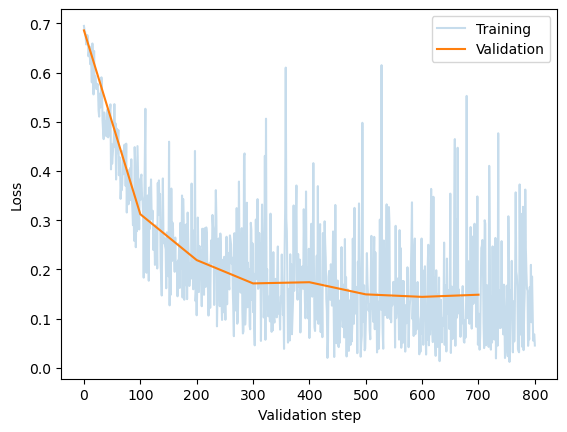

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([i[0] for i in train_loss_history], [i[1] for i in train_loss_history], alpha=0.25)
ax.plot([i[0] for i in val_loss_history], [i[1] for i in val_loss_history])
ax.legend(["Training", "Validation"])
ax.set_xlabel("Validation step")
ax.set_ylabel("Loss")
plt.show()

# Notes on performance tuning

We haven't done a lot to make this model run as fast as possible.  There are ways to speed it up, but _it will always be slow._  Some things we could do:
- Pre-compute the tokenization when we create the datasets, rather than doing this inside the loops.
- Use multi-GPU parallelism (if available).
- Use mixed precision training, which uses less precise (but faster) numeric formats at points in the model where precision isn't critical.
- Additional hardware-specific tweaks like `bfloat16` or `tensorfloat` numeric formats.
- Use a faster self-attention calculation like Flash Attention (not supported on older hardware).
- Tweak the batch size, learning rate, optimizer, and other optimizer parameters to help the model converge more quickly.

This is not an exhaustive list.

We can also reduce the memory footprint--but not necessarily the compute cost--to allow us to train larger models:
- "Parameter-efficient fine-tuning" (PEFT) methods.  These use smaller, compressed representations of the model's parameters, and update those representations rather than the full model.  This doesn't speed things up, but can massively reduce memory usage.  Low-Rank Adaptation (LoRA) is one of the more popular techniques here.
- Gradient accumulation.  Do more forward passes and compute a rolling average of the gradients.  This effectively allows you to use massive batch sizes, with a small speed penalty.

And, of course, we can just use a simpler model that runs faster--that would let us try more things out in rapid succession, and find some optimal configurations, which might be as good as the LLM (or better!).